In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 32
birdclef_epoch = 50

# Learning Rate.
learning_rate_2 = 0.001

# L2 Regularization Hyperparamter
weight_decay_2 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, loss, epoch, index):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt')
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        epoch_losses = ckpt['loss']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e < saved_epoch:
            continue
        
        if len(val_losses) == 0 and saved_epoch > -1:
            acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
            val_losses.append(acc)
            train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
            log_scores.append(log_score)
            fbeta_scores.append(fbeta_score)
            
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # every epoch, save the model
        checkpoint(model, optimizer, epoch_losses, e, index)
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate_2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                               | 1/1178 [00:03<1:06:50,  3.41s/it]

Iteration 0, loss = 6.2334


  9%|██████▊                                                                        | 101/1178 [00:54<08:59,  2.00it/s]

Iteration 100, loss = 5.7753


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:15,  1.97it/s]

Iteration 200, loss = 5.7950


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:46,  1.88it/s]

Iteration 300, loss = 5.7600


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:42,  1.93it/s]

Iteration 400, loss = 5.8858


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:55,  1.90it/s]

Iteration 500, loss = 5.8646


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:17,  1.82it/s]

Iteration 600, loss = 5.9671


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:11,  1.90it/s]

Iteration 700, loss = 5.9104


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:53<03:10,  1.98it/s]

Iteration 800, loss = 5.7414


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:44<02:27,  1.87it/s]

Iteration 900, loss = 5.5071


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:35<01:33,  1.90it/s]

Iteration 1000, loss = 5.8267


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:26<00:37,  2.04it/s]

Iteration 1100, loss = 5.4721


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:05<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 189 / 12575 correct (1.50)
Log Loss score:	5.68
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 2


  0%|                                                                                 | 1/1178 [00:00<11:16,  1.74it/s]

Iteration 0, loss = 5.7434


  9%|██████▊                                                                        | 101/1178 [00:53<09:49,  1.83it/s]

Iteration 100, loss = 5.8858


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:17,  1.96it/s]

Iteration 200, loss = 5.9212


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:13,  2.02it/s]

Iteration 300, loss = 5.8907


 34%|██████████████████████████▉                                                    | 401/1178 [03:24<06:26,  2.01it/s]

Iteration 400, loss = 5.8110


 43%|█████████████████████████████████▌                                             | 501/1178 [04:15<06:33,  1.72it/s]

Iteration 500, loss = 5.8386


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:06<04:45,  2.02it/s]

Iteration 600, loss = 5.7129


 60%|███████████████████████████████████████████████                                | 701/1178 [05:56<04:13,  1.88it/s]

Iteration 700, loss = 5.7488


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:47<03:12,  1.96it/s]

Iteration 800, loss = 5.6187


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:39<02:14,  2.06it/s]

Iteration 900, loss = 5.9905


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:30<01:32,  1.91it/s]

Iteration 1000, loss = 5.8768


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:20<00:35,  2.15it/s]

Iteration 1100, loss = 5.7089


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [09:59<00:00,  1.97it/s]


Checking accuracy score on validation set.

Accuracy: 204 / 12575 correct (1.62)
Log Loss score:	5.68
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 3


  0%|                                                                                 | 1/1178 [00:00<12:29,  1.57it/s]

Iteration 0, loss = 5.8282


  9%|██████▊                                                                        | 101/1178 [00:51<10:15,  1.75it/s]

Iteration 100, loss = 5.5413


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:13,  1.98it/s]

Iteration 200, loss = 5.6462


 26%|████████████████████▏                                                          | 301/1178 [02:33<07:21,  1.99it/s]

Iteration 300, loss = 5.7208


 34%|██████████████████████████▉                                                    | 401/1178 [03:24<06:29,  2.00it/s]

Iteration 400, loss = 5.4365


 43%|█████████████████████████████████▌                                             | 501/1178 [04:15<05:42,  1.97it/s]

Iteration 500, loss = 5.6384


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:07<04:41,  2.05it/s]

Iteration 600, loss = 5.5091


 60%|███████████████████████████████████████████████                                | 701/1178 [05:57<03:52,  2.05it/s]

Iteration 700, loss = 5.1789


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:49<03:24,  1.84it/s]

Iteration 800, loss = 5.2073


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:40<02:32,  1.82it/s]

Iteration 900, loss = 5.1440


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:32<01:28,  2.00it/s]

Iteration 1000, loss = 5.4804


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:22<00:42,  1.82it/s]

Iteration 1100, loss = 5.2286


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:02<00:00,  1.95it/s]


Checking accuracy score on validation set.

Accuracy: 494 / 12575 correct (3.93)
Log Loss score:	5.24
Fbeta-score (beta=1): 	0.04
Training model 2, epoch 4


  0%|                                                                                 | 1/1178 [00:00<12:05,  1.62it/s]

Iteration 0, loss = 5.2808


  9%|██████▊                                                                        | 101/1178 [00:52<09:11,  1.95it/s]

Iteration 100, loss = 5.2894


 17%|█████████████▍                                                                 | 201/1178 [01:44<09:07,  1.79it/s]

Iteration 200, loss = 5.2697


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:47,  1.88it/s]

Iteration 300, loss = 5.0863


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:45,  1.92it/s]

Iteration 400, loss = 4.9754


 43%|█████████████████████████████████▌                                             | 501/1178 [04:16<05:09,  2.19it/s]

Iteration 500, loss = 4.9197


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:07<04:44,  2.03it/s]

Iteration 600, loss = 4.8447


 60%|███████████████████████████████████████████████                                | 701/1178 [05:57<03:52,  2.05it/s]

Iteration 700, loss = 4.9959


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:48<03:13,  1.95it/s]

Iteration 800, loss = 4.9392


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:40<02:22,  1.94it/s]

Iteration 900, loss = 5.2143


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:32<01:31,  1.94it/s]

Iteration 1000, loss = 4.9073


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:23<00:39,  1.95it/s]

Iteration 1100, loss = 4.9382


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:02<00:00,  1.96it/s]


Checking accuracy score on validation set.

Accuracy: 942 / 12575 correct (7.49)
Log Loss score:	4.89
Fbeta-score (beta=1): 	0.07
Training model 2, epoch 5


  0%|                                                                                 | 1/1178 [00:00<10:26,  1.88it/s]

Iteration 0, loss = 4.6618


  9%|██████▊                                                                        | 101/1178 [00:50<09:18,  1.93it/s]

Iteration 100, loss = 5.1522


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:46,  1.86it/s]

Iteration 200, loss = 4.9210


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:08,  2.04it/s]

Iteration 300, loss = 4.8405


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:45,  1.92it/s]

Iteration 400, loss = 4.3973


 43%|█████████████████████████████████▌                                             | 501/1178 [04:17<05:33,  2.03it/s]

Iteration 500, loss = 4.7150


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:08<04:46,  2.01it/s]

Iteration 600, loss = 4.6594


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<04:09,  1.91it/s]

Iteration 700, loss = 5.1179


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:52<03:07,  2.01it/s]

Iteration 800, loss = 4.5503


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:43<02:22,  1.94it/s]

Iteration 900, loss = 4.7515


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:35<01:34,  1.87it/s]

Iteration 1000, loss = 4.5684


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:27<00:41,  1.85it/s]

Iteration 1100, loss = 5.0292


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:06<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 1229 / 12575 correct (9.77)
Log Loss score:	4.72
Fbeta-score (beta=1): 	0.10
Training model 2, epoch 6


  0%|                                                                                 | 1/1178 [00:00<11:35,  1.69it/s]

Iteration 0, loss = 4.6792


  9%|██████▊                                                                        | 101/1178 [00:52<09:43,  1.85it/s]

Iteration 100, loss = 4.5381


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:12,  1.98it/s]

Iteration 200, loss = 4.5310


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:53,  1.85it/s]

Iteration 300, loss = 4.6812


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:34,  1.97it/s]

Iteration 400, loss = 4.2290


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<06:05,  1.85it/s]

Iteration 500, loss = 4.5578


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:08<04:42,  2.04it/s]

Iteration 600, loss = 4.2595


 60%|███████████████████████████████████████████████                                | 701/1178 [05:59<03:58,  2.00it/s]

Iteration 700, loss = 4.2571


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:50<03:21,  1.87it/s]

Iteration 800, loss = 4.9305


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:41<02:16,  2.02it/s]

Iteration 900, loss = 5.0214


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:32<01:29,  1.98it/s]

Iteration 1000, loss = 3.7612


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:24<00:39,  1.94it/s]

Iteration 1100, loss = 4.2788


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:04<00:00,  1.95it/s]


Checking accuracy score on validation set.

Accuracy: 1494 / 12575 correct (11.88)
Log Loss score:	4.51
Fbeta-score (beta=1): 	0.12
Training model 2, epoch 7


  0%|                                                                                 | 1/1178 [00:00<12:33,  1.56it/s]

Iteration 0, loss = 4.1927


  9%|██████▊                                                                        | 101/1178 [00:52<09:21,  1.92it/s]

Iteration 100, loss = 4.3493


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:26,  1.93it/s]

Iteration 200, loss = 4.1632


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:15,  2.02it/s]

Iteration 300, loss = 4.2638


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:41,  1.94it/s]

Iteration 400, loss = 4.3373


 43%|█████████████████████████████████▌                                             | 501/1178 [04:17<05:30,  2.05it/s]

Iteration 500, loss = 4.5652


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:09<04:52,  1.97it/s]

Iteration 600, loss = 4.0435


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<04:07,  1.93it/s]

Iteration 700, loss = 3.7951


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:53<03:23,  1.85it/s]

Iteration 800, loss = 4.3574


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:43<02:17,  2.02it/s]

Iteration 900, loss = 4.2696


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:34<01:28,  2.00it/s]

Iteration 1000, loss = 3.7537


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:26<00:39,  1.96it/s]

Iteration 1100, loss = 4.1468


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:04<00:00,  1.95it/s]


Checking accuracy score on validation set.

Accuracy: 1910 / 12575 correct (15.19)
Log Loss score:	4.33
Fbeta-score (beta=1): 	0.15
Training model 2, epoch 8


  0%|                                                                                 | 1/1178 [00:00<11:47,  1.66it/s]

Iteration 0, loss = 3.8800


  9%|██████▊                                                                        | 101/1178 [00:52<09:35,  1.87it/s]

Iteration 100, loss = 4.2339


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:17,  1.97it/s]

Iteration 200, loss = 4.4940


 26%|████████████████████▏                                                          | 301/1178 [02:35<06:48,  2.15it/s]

Iteration 300, loss = 4.2639


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<05:57,  2.17it/s]

Iteration 400, loss = 4.4596


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<05:42,  1.98it/s]

Iteration 500, loss = 4.1219


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:09<04:33,  2.11it/s]

Iteration 600, loss = 4.3912


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<04:05,  1.94it/s]

Iteration 700, loss = 4.2223


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:53<03:13,  1.95it/s]

Iteration 800, loss = 4.0932


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:45<02:26,  1.89it/s]

Iteration 900, loss = 4.4920


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:36<01:27,  2.03it/s]

Iteration 1000, loss = 4.3260


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:28<00:47,  1.63it/s]

Iteration 1100, loss = 4.1079


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:08<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 2181 / 12575 correct (17.34)
Log Loss score:	4.19
Fbeta-score (beta=1): 	0.17
Training model 2, epoch 9


  0%|                                                                                 | 1/1178 [00:00<12:50,  1.53it/s]

Iteration 0, loss = 3.4698


  9%|██████▊                                                                        | 101/1178 [00:51<09:41,  1.85it/s]

Iteration 100, loss = 3.7181


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:00,  2.03it/s]

Iteration 200, loss = 4.0224


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:48,  1.87it/s]

Iteration 300, loss = 4.0769


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:45,  1.92it/s]

Iteration 400, loss = 3.8842


 43%|█████████████████████████████████▌                                             | 501/1178 [04:17<05:38,  2.00it/s]

Iteration 500, loss = 4.4741


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:09<05:01,  1.91it/s]

Iteration 600, loss = 4.3305


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<03:58,  2.00it/s]

Iteration 700, loss = 3.6042


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:52<03:02,  2.06it/s]

Iteration 800, loss = 3.3267


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:43<02:20,  1.97it/s]

Iteration 900, loss = 3.5720


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:35<01:28,  2.00it/s]

Iteration 1000, loss = 3.7646


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:27<00:38,  2.00it/s]

Iteration 1100, loss = 4.2250


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:06<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 2399 / 12575 correct (19.08)
Log Loss score:	4.07
Fbeta-score (beta=1): 	0.19
Training model 2, epoch 10


  0%|                                                                                 | 1/1178 [00:00<09:17,  2.11it/s]

Iteration 0, loss = 4.2964


  9%|██████▊                                                                        | 101/1178 [00:51<09:21,  1.92it/s]

Iteration 100, loss = 4.1342


 17%|█████████████▍                                                                 | 201/1178 [01:42<08:00,  2.03it/s]

Iteration 200, loss = 3.5547


 26%|████████████████████▏                                                          | 301/1178 [02:34<06:58,  2.10it/s]

Iteration 300, loss = 3.3456


 34%|██████████████████████████▉                                                    | 401/1178 [03:25<06:42,  1.93it/s]

Iteration 400, loss = 3.3249


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<06:06,  1.85it/s]

Iteration 500, loss = 4.1924


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:09<04:43,  2.04it/s]

Iteration 600, loss = 3.8940


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<03:55,  2.03it/s]

Iteration 700, loss = 3.8870


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:52<03:27,  1.82it/s]

Iteration 800, loss = 4.1248


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:43<02:15,  2.04it/s]

Iteration 900, loss = 3.5182


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:34<01:36,  1.84it/s]

Iteration 1000, loss = 4.5564


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:27<00:43,  1.77it/s]

Iteration 1100, loss = 3.7955


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:06<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 2655 / 12575 correct (21.11)
Log Loss score:	3.97
Fbeta-score (beta=1): 	0.21
Training model 2, epoch 11


  0%|                                                                                 | 1/1178 [00:00<12:29,  1.57it/s]

Iteration 0, loss = 3.5345


  9%|██████▊                                                                        | 101/1178 [00:51<08:46,  2.05it/s]

Iteration 100, loss = 4.0692


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:44,  1.86it/s]

Iteration 200, loss = 4.2620


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:34,  1.93it/s]

Iteration 300, loss = 3.7302


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<05:56,  2.18it/s]

Iteration 400, loss = 3.3170


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<06:10,  1.83it/s]

Iteration 500, loss = 4.6066


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<04:46,  2.01it/s]

Iteration 600, loss = 3.4065


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:11,  1.90it/s]

Iteration 700, loss = 4.0901


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:24,  1.84it/s]

Iteration 800, loss = 3.6237


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:46<02:18,  2.01it/s]

Iteration 900, loss = 3.3727


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:37<01:26,  2.04it/s]

Iteration 1000, loss = 3.6326


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:28<00:43,  1.78it/s]

Iteration 1100, loss = 4.3025


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:08<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 2774 / 12575 correct (22.06)
Log Loss score:	3.96
Fbeta-score (beta=1): 	0.22
Training model 2, epoch 12


  0%|                                                                                 | 1/1178 [00:00<12:12,  1.61it/s]

Iteration 0, loss = 3.1096


  9%|██████▊                                                                        | 101/1178 [00:50<09:26,  1.90it/s]

Iteration 100, loss = 3.9833


 17%|█████████████▍                                                                 | 201/1178 [01:41<08:14,  1.98it/s]

Iteration 200, loss = 4.1783


 26%|████████████████████▏                                                          | 301/1178 [02:33<07:31,  1.94it/s]

Iteration 300, loss = 3.5783


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:33,  1.97it/s]

Iteration 400, loss = 3.3768


 43%|█████████████████████████████████▌                                             | 501/1178 [04:17<06:05,  1.85it/s]

Iteration 500, loss = 3.6827


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:07<04:48,  2.00it/s]

Iteration 600, loss = 3.3965


 60%|███████████████████████████████████████████████                                | 701/1178 [05:59<04:05,  1.95it/s]

Iteration 700, loss = 3.5588


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:51<03:09,  1.99it/s]

Iteration 800, loss = 4.2367


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:43<02:17,  2.01it/s]

Iteration 900, loss = 4.0224


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:34<01:28,  2.00it/s]

Iteration 1000, loss = 3.8819


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:27<00:41,  1.88it/s]

Iteration 1100, loss = 3.4326


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:07<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 2933 / 12575 correct (23.32)
Log Loss score:	3.85
Fbeta-score (beta=1): 	0.23
Training model 2, epoch 13


  0%|                                                                                 | 1/1178 [00:00<11:07,  1.76it/s]

Iteration 0, loss = 2.8544


  9%|██████▊                                                                        | 101/1178 [00:52<09:38,  1.86it/s]

Iteration 100, loss = 3.3013


 17%|█████████████▍                                                                 | 201/1178 [01:44<09:14,  1.76it/s]

Iteration 200, loss = 2.9216


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:35,  1.93it/s]

Iteration 300, loss = 3.5749


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<07:05,  1.83it/s]

Iteration 400, loss = 3.4953


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:45,  1.96it/s]

Iteration 500, loss = 3.2754


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<04:55,  1.96it/s]

Iteration 600, loss = 3.6434


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<03:52,  2.05it/s]

Iteration 700, loss = 3.6343


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:53<03:11,  1.97it/s]

Iteration 800, loss = 3.4610


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:45<02:31,  1.83it/s]

Iteration 900, loss = 3.3838


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:37<01:26,  2.04it/s]

Iteration 1000, loss = 3.9237


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:29<00:39,  1.93it/s]

Iteration 1100, loss = 3.2838


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:08<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3016 / 12575 correct (23.98)
Log Loss score:	3.81
Fbeta-score (beta=1): 	0.24
Training model 2, epoch 14


  0%|                                                                                 | 1/1178 [00:00<12:30,  1.57it/s]

Iteration 0, loss = 2.9694


  9%|██████▊                                                                        | 101/1178 [00:52<09:36,  1.87it/s]

Iteration 100, loss = 3.3180


 17%|█████████████▍                                                                 | 201/1178 [01:43<09:18,  1.75it/s]

Iteration 200, loss = 3.0445


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:53,  1.85it/s]

Iteration 300, loss = 3.1512


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:59,  1.85it/s]

Iteration 400, loss = 3.3918


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<06:03,  1.86it/s]

Iteration 500, loss = 3.1044


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<04:55,  1.95it/s]

Iteration 600, loss = 4.3295


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<03:55,  2.02it/s]

Iteration 700, loss = 3.4365


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:15,  1.93it/s]

Iteration 800, loss = 3.4956


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:45<02:27,  1.88it/s]

Iteration 900, loss = 2.8524


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:37<01:26,  2.05it/s]

Iteration 1000, loss = 2.6975


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:29<00:37,  2.04it/s]

Iteration 1100, loss = 3.6367


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:09<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3137 / 12575 correct (24.95)
Log Loss score:	3.77
Fbeta-score (beta=1): 	0.25
Training model 2, epoch 15


  0%|                                                                                 | 1/1178 [00:00<12:12,  1.61it/s]

Iteration 0, loss = 2.9371


  9%|██████▊                                                                        | 101/1178 [00:52<09:50,  1.82it/s]

Iteration 100, loss = 3.3669


 17%|█████████████▍                                                                 | 201/1178 [01:43<09:00,  1.81it/s]

Iteration 200, loss = 3.4909


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:38,  1.91it/s]

Iteration 300, loss = 3.5082


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:39,  1.94it/s]

Iteration 400, loss = 3.2033


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<06:00,  1.88it/s]

Iteration 500, loss = 3.4587


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:13,  1.84it/s]

Iteration 600, loss = 3.2681


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<03:52,  2.05it/s]

Iteration 700, loss = 3.3532


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:53<03:05,  2.03it/s]

Iteration 800, loss = 3.3020


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:45<02:31,  1.83it/s]

Iteration 900, loss = 3.7527


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:37<01:47,  1.64it/s]

Iteration 1000, loss = 2.8977


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:29<00:38,  2.03it/s]

Iteration 1100, loss = 2.9718


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:08<00:00,  1.94it/s]


Checking accuracy score on validation set.

Accuracy: 3391 / 12575 correct (26.97)
Log Loss score:	3.68
Fbeta-score (beta=1): 	0.27
Training model 2, epoch 16


  0%|                                                                                 | 1/1178 [00:00<11:53,  1.65it/s]

Iteration 0, loss = 4.0034


  9%|██████▊                                                                        | 101/1178 [00:51<08:29,  2.11it/s]

Iteration 100, loss = 3.1335


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:02,  2.02it/s]

Iteration 200, loss = 2.8293


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:51,  1.86it/s]

Iteration 300, loss = 4.2226


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<07:05,  1.83it/s]

Iteration 400, loss = 3.1987


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<05:30,  2.05it/s]

Iteration 500, loss = 2.6603


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:03,  1.90it/s]

Iteration 600, loss = 3.5905


 60%|███████████████████████████████████████████████                                | 701/1178 [06:01<04:00,  1.99it/s]

Iteration 700, loss = 3.5417


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:14,  1.94it/s]

Iteration 800, loss = 3.4288


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:45<02:23,  1.93it/s]

Iteration 900, loss = 2.9891


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:36<01:26,  2.05it/s]

Iteration 1000, loss = 4.2970


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:28<00:38,  2.01it/s]

Iteration 1100, loss = 3.3202


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:09<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3470 / 12575 correct (27.59)
Log Loss score:	3.66
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 17


  0%|                                                                                 | 1/1178 [00:00<15:42,  1.25it/s]

Iteration 0, loss = 3.3618


  9%|██████▊                                                                        | 101/1178 [00:52<09:16,  1.94it/s]

Iteration 100, loss = 2.4886


 17%|█████████████▍                                                                 | 201/1178 [01:44<07:51,  2.07it/s]

Iteration 200, loss = 2.9827


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:15,  2.02it/s]

Iteration 300, loss = 2.4666


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:35,  1.96it/s]

Iteration 400, loss = 2.5625


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<05:32,  2.04it/s]

Iteration 500, loss = 3.1300


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:12,  1.85it/s]

Iteration 600, loss = 3.3162


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:23,  1.81it/s]

Iteration 700, loss = 3.6941


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:20,  1.88it/s]

Iteration 800, loss = 3.1564


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:16,  2.03it/s]

Iteration 900, loss = 3.0688


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:40,  1.75it/s]

Iteration 1000, loss = 3.0075


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:40,  1.90it/s]

Iteration 1100, loss = 2.8520


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3573 / 12575 correct (28.41)
Log Loss score:	3.63
Fbeta-score (beta=1): 	0.28
Training model 2, epoch 18


  0%|                                                                                 | 1/1178 [00:00<13:36,  1.44it/s]

Iteration 0, loss = 2.8677


  9%|██████▊                                                                        | 101/1178 [00:51<09:01,  1.99it/s]

Iteration 100, loss = 3.1732


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:39,  1.88it/s]

Iteration 200, loss = 2.6379


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:51,  1.86it/s]

Iteration 300, loss = 3.3512


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:14,  2.07it/s]

Iteration 400, loss = 3.0752


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<06:02,  1.87it/s]

Iteration 500, loss = 2.4005


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:11<05:28,  1.76it/s]

Iteration 600, loss = 3.8839


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<03:45,  2.12it/s]

Iteration 700, loss = 3.3981


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:16,  1.92it/s]

Iteration 800, loss = 3.4451


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:46<02:24,  1.92it/s]

Iteration 900, loss = 3.2317


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:37<01:37,  1.81it/s]

Iteration 1000, loss = 3.7323


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:29<00:38,  1.99it/s]

Iteration 1100, loss = 3.0103


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:08<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3648 / 12575 correct (29.01)
Log Loss score:	3.65
Fbeta-score (beta=1): 	0.29
Training model 2, epoch 19


  0%|                                                                                 | 1/1178 [00:00<10:30,  1.87it/s]

Iteration 0, loss = 2.8871


  9%|██████▊                                                                        | 101/1178 [00:52<09:41,  1.85it/s]

Iteration 100, loss = 3.1185


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:27,  1.92it/s]

Iteration 200, loss = 3.2129


 26%|████████████████████▏                                                          | 301/1178 [02:38<08:24,  1.74it/s]

Iteration 300, loss = 2.5822


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:11,  2.09it/s]

Iteration 400, loss = 2.8563


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:46,  1.95it/s]

Iteration 500, loss = 3.3220


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<05:07,  1.88it/s]

Iteration 600, loss = 2.9055


 60%|███████████████████████████████████████████████                                | 701/1178 [06:04<04:17,  1.85it/s]

Iteration 700, loss = 3.4114


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:04,  2.05it/s]

Iteration 800, loss = 2.9714


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:46<02:17,  2.01it/s]

Iteration 900, loss = 2.8021


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:36<01:28,  1.99it/s]

Iteration 1000, loss = 3.2123


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:28<00:40,  1.91it/s]

Iteration 1100, loss = 3.1268


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:08<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3799 / 12575 correct (30.21)
Log Loss score:	3.66
Fbeta-score (beta=1): 	0.30
Training model 2, epoch 20


  0%|                                                                                 | 1/1178 [00:00<11:34,  1.69it/s]

Iteration 0, loss = 3.2077


  9%|██████▊                                                                        | 101/1178 [00:52<09:58,  1.80it/s]

Iteration 100, loss = 3.3160


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:08,  2.00it/s]

Iteration 200, loss = 3.1507


 26%|████████████████████▏                                                          | 301/1178 [02:36<08:03,  1.81it/s]

Iteration 300, loss = 2.5921


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<06:57,  1.86it/s]

Iteration 400, loss = 3.0673


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:33,  2.03it/s]

Iteration 500, loss = 3.3620


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<04:54,  1.96it/s]

Iteration 600, loss = 2.6098


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:07,  1.93it/s]

Iteration 700, loss = 2.2607


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:16,  1.92it/s]

Iteration 800, loss = 3.4515


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:49,  1.63it/s]

Iteration 900, loss = 2.8216


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:31,  1.93it/s]

Iteration 1000, loss = 3.1215


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:40,  1.91it/s]

Iteration 1100, loss = 2.3010


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3936 / 12575 correct (31.30)
Log Loss score:	3.53
Fbeta-score (beta=1): 	0.31
Training model 2, epoch 21


  0%|                                                                                 | 1/1178 [00:00<10:36,  1.85it/s]

Iteration 0, loss = 2.9084


  9%|██████▊                                                                        | 101/1178 [00:52<09:50,  1.82it/s]

Iteration 100, loss = 3.1785


 17%|█████████████▍                                                                 | 201/1178 [01:42<08:11,  1.99it/s]

Iteration 200, loss = 2.2041


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:41,  1.90it/s]

Iteration 300, loss = 3.1154


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:27,  2.00it/s]

Iteration 400, loss = 2.3282


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:40,  1.99it/s]

Iteration 500, loss = 2.5786


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:15,  1.83it/s]

Iteration 600, loss = 3.0911


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<03:54,  2.03it/s]

Iteration 700, loss = 2.7897


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:22,  1.86it/s]

Iteration 800, loss = 3.2468


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:46<02:37,  1.76it/s]

Iteration 900, loss = 3.1774


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:32,  1.91it/s]

Iteration 1000, loss = 2.2478


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:39,  1.94it/s]

Iteration 1100, loss = 2.8625


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 3981 / 12575 correct (31.66)
Log Loss score:	3.60
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 22


  0%|                                                                                 | 1/1178 [00:00<12:59,  1.51it/s]

Iteration 0, loss = 2.8293


  9%|██████▊                                                                        | 101/1178 [00:51<09:01,  1.99it/s]

Iteration 100, loss = 2.5449


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:37,  1.89it/s]

Iteration 200, loss = 2.5414


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:45,  1.88it/s]

Iteration 300, loss = 2.6632


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:40,  1.94it/s]

Iteration 400, loss = 2.9524


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:47,  1.95it/s]

Iteration 500, loss = 2.5459


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<04:30,  2.13it/s]

Iteration 600, loss = 2.6448


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:06,  1.93it/s]

Iteration 700, loss = 2.6339


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:08,  2.00it/s]

Iteration 800, loss = 2.7163


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:30,  1.84it/s]

Iteration 900, loss = 2.0388


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:32,  1.92it/s]

Iteration 1000, loss = 2.5848


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:40,  1.89it/s]

Iteration 1100, loss = 2.5954


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4054 / 12575 correct (32.24)
Log Loss score:	3.59
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 23


  0%|                                                                                 | 1/1178 [00:00<11:48,  1.66it/s]

Iteration 0, loss = 2.3643


  9%|██████▊                                                                        | 101/1178 [00:52<09:32,  1.88it/s]

Iteration 100, loss = 2.4531


 17%|█████████████▍                                                                 | 201/1178 [01:44<09:19,  1.75it/s]

Iteration 200, loss = 2.8275


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:11,  2.03it/s]

Iteration 300, loss = 2.7421


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:17,  2.06it/s]

Iteration 400, loss = 3.1851


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:52,  1.92it/s]

Iteration 500, loss = 2.2119


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<04:58,  1.94it/s]

Iteration 600, loss = 2.8626


 60%|███████████████████████████████████████████████                                | 701/1178 [06:04<04:06,  1.93it/s]

Iteration 700, loss = 2.2641


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:30,  1.79it/s]

Iteration 800, loss = 2.2935


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:21,  1.96it/s]

Iteration 900, loss = 3.1903


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:44,  1.69it/s]

Iteration 1000, loss = 3.0332


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:33<00:41,  1.84it/s]

Iteration 1100, loss = 2.4962


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:13<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4084 / 12575 correct (32.48)
Log Loss score:	3.63
Fbeta-score (beta=1): 	0.32
Training model 2, epoch 24


  0%|                                                                                 | 1/1178 [00:00<10:44,  1.82it/s]

Iteration 0, loss = 2.7218


  9%|██████▊                                                                        | 101/1178 [00:52<09:43,  1.85it/s]

Iteration 100, loss = 2.2562


 17%|█████████████▍                                                                 | 201/1178 [01:43<07:50,  2.07it/s]

Iteration 200, loss = 2.2442


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:37,  1.92it/s]

Iteration 300, loss = 2.3777


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:17,  2.06it/s]

Iteration 400, loss = 2.3357


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:35,  2.02it/s]

Iteration 500, loss = 2.3335


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:11<04:56,  1.95it/s]

Iteration 600, loss = 2.9963


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:07,  1.92it/s]

Iteration 700, loss = 2.1977


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:07,  2.01it/s]

Iteration 800, loss = 2.7441


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:26,  1.89it/s]

Iteration 900, loss = 2.7963


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:42,  1.72it/s]

Iteration 1000, loss = 2.6013


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:39,  1.93it/s]

Iteration 1100, loss = 2.8782


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4161 / 12575 correct (33.09)
Log Loss score:	3.60
Fbeta-score (beta=1): 	0.33
Training model 2, epoch 25


  0%|                                                                                 | 1/1178 [00:00<11:37,  1.69it/s]

Iteration 0, loss = 2.9317


  9%|██████▊                                                                        | 101/1178 [00:52<09:52,  1.82it/s]

Iteration 100, loss = 2.8750


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:12,  1.98it/s]

Iteration 200, loss = 1.6929


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:44,  1.89it/s]

Iteration 300, loss = 2.3624


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:44,  1.92it/s]

Iteration 400, loss = 1.8421


 43%|█████████████████████████████████▌                                             | 501/1178 [04:21<05:31,  2.04it/s]

Iteration 500, loss = 2.3002


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:13<04:56,  1.95it/s]

Iteration 600, loss = 2.2927


 60%|███████████████████████████████████████████████                                | 701/1178 [06:05<04:13,  1.89it/s]

Iteration 700, loss = 2.4264


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:48,  1.65it/s]

Iteration 800, loss = 2.5636


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:49<02:14,  2.07it/s]

Iteration 900, loss = 2.3316


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:23,  2.12it/s]

Iteration 1000, loss = 2.7167


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:37,  2.03it/s]

Iteration 1100, loss = 1.7061


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4248 / 12575 correct (33.78)
Log Loss score:	3.61
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 26


  0%|                                                                                 | 1/1178 [00:00<09:47,  2.00it/s]

Iteration 0, loss = 2.2355


  9%|██████▊                                                                        | 101/1178 [00:51<09:46,  1.84it/s]

Iteration 100, loss = 2.1653


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:28,  1.92it/s]

Iteration 200, loss = 2.1982


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:13,  2.02it/s]

Iteration 300, loss = 2.4282


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:39,  1.95it/s]

Iteration 400, loss = 2.1821


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<05:51,  1.92it/s]

Iteration 500, loss = 2.4976


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:44,  1.68it/s]

Iteration 600, loss = 2.3713


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:22,  1.81it/s]

Iteration 700, loss = 2.5463


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:19,  1.89it/s]

Iteration 800, loss = 1.9661


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:22,  1.95it/s]

Iteration 900, loss = 2.0583


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:38<01:28,  2.01it/s]

Iteration 1000, loss = 1.8474


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:42,  1.80it/s]

Iteration 1100, loss = 2.1225


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4318 / 12575 correct (34.34)
Log Loss score:	3.69
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 27


  0%|                                                                                 | 1/1178 [00:00<12:22,  1.58it/s]

Iteration 0, loss = 2.1152


  9%|██████▊                                                                        | 101/1178 [00:52<08:44,  2.05it/s]

Iteration 100, loss = 1.9129


 17%|█████████████▍                                                                 | 201/1178 [01:44<09:12,  1.77it/s]

Iteration 200, loss = 2.1747


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:44,  1.89it/s]

Iteration 300, loss = 1.3951


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<06:37,  1.95it/s]

Iteration 400, loss = 1.7436


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:47,  1.95it/s]

Iteration 500, loss = 2.0707


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<04:48,  2.00it/s]

Iteration 600, loss = 1.7203


 60%|███████████████████████████████████████████████                                | 701/1178 [06:04<04:19,  1.84it/s]

Iteration 700, loss = 1.9203


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:56<03:12,  1.96it/s]

Iteration 800, loss = 1.7588


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:19,  1.99it/s]

Iteration 900, loss = 2.3513


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:41<01:24,  2.09it/s]

Iteration 1000, loss = 2.3632


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:37,  2.04it/s]

Iteration 1100, loss = 1.6018


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:12<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4301 / 12575 correct (34.20)
Log Loss score:	3.80
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 28


  0%|                                                                                 | 1/1178 [00:00<12:08,  1.62it/s]

Iteration 0, loss = 1.9430


  9%|██████▊                                                                        | 101/1178 [00:53<08:49,  2.03it/s]

Iteration 100, loss = 1.6425


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:25,  1.93it/s]

Iteration 200, loss = 1.9742


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:54,  1.85it/s]

Iteration 300, loss = 1.9641


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:39,  1.94it/s]

Iteration 400, loss = 1.6002


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:53,  1.91it/s]

Iteration 500, loss = 2.0464


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<05:12,  1.84it/s]

Iteration 600, loss = 1.7461


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:08,  1.92it/s]

Iteration 700, loss = 1.7799


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:09,  1.99it/s]

Iteration 800, loss = 1.6880


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:15,  2.04it/s]

Iteration 900, loss = 1.9384


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:35,  1.86it/s]

Iteration 1000, loss = 2.1880


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:40,  1.92it/s]

Iteration 1100, loss = 2.1034


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4372 / 12575 correct (34.77)
Log Loss score:	3.76
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 29


  0%|                                                                                 | 1/1178 [00:00<12:54,  1.52it/s]

Iteration 0, loss = 2.9899


  9%|██████▊                                                                        | 101/1178 [00:52<09:47,  1.83it/s]

Iteration 100, loss = 1.9116


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:04,  2.02it/s]

Iteration 200, loss = 1.9760


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:55,  1.84it/s]

Iteration 300, loss = 1.9593


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<06:58,  1.85it/s]

Iteration 400, loss = 1.4412


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<05:36,  2.01it/s]

Iteration 500, loss = 2.4092


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<04:48,  2.00it/s]

Iteration 600, loss = 2.9003


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:10,  1.91it/s]

Iteration 700, loss = 2.4068


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:07,  2.01it/s]

Iteration 800, loss = 1.8103


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:18,  2.00it/s]

Iteration 900, loss = 1.8176


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:31,  1.93it/s]

Iteration 1000, loss = 1.6026


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:33<00:44,  1.71it/s]

Iteration 1100, loss = 2.3177


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:13<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4374 / 12575 correct (34.78)
Log Loss score:	3.87
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 30


  0%|                                                                                 | 1/1178 [00:00<11:21,  1.73it/s]

Iteration 0, loss = 1.2080


  9%|██████▊                                                                        | 101/1178 [00:52<09:26,  1.90it/s]

Iteration 100, loss = 1.9168


 17%|█████████████▍                                                                 | 201/1178 [01:45<09:09,  1.78it/s]

Iteration 200, loss = 1.6049


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:36,  1.92it/s]

Iteration 300, loss = 1.7381


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<06:36,  1.96it/s]

Iteration 400, loss = 1.8357


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:40,  1.99it/s]

Iteration 500, loss = 1.8692


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:13<05:05,  1.89it/s]

Iteration 600, loss = 1.9294


 60%|███████████████████████████████████████████████                                | 701/1178 [06:05<04:00,  1.98it/s]

Iteration 700, loss = 1.5918


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:08,  2.00it/s]

Iteration 800, loss = 1.2794


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:12,  2.09it/s]

Iteration 900, loss = 2.1967


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:29,  1.98it/s]

Iteration 1000, loss = 2.4375


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:40,  1.91it/s]

Iteration 1100, loss = 1.4617


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4322 / 12575 correct (34.37)
Log Loss score:	3.95
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 31


  0%|                                                                                 | 1/1178 [00:00<10:32,  1.86it/s]

Iteration 0, loss = 1.9577


  9%|██████▊                                                                        | 101/1178 [00:52<10:14,  1.75it/s]

Iteration 100, loss = 1.2087


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:38,  1.88it/s]

Iteration 200, loss = 2.0626


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:11,  2.03it/s]

Iteration 300, loss = 1.7616


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<07:01,  1.84it/s]

Iteration 400, loss = 1.5008


 43%|█████████████████████████████████▌                                             | 501/1178 [04:21<06:13,  1.81it/s]

Iteration 500, loss = 1.5407


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<04:37,  2.08it/s]

Iteration 600, loss = 1.4794


 60%|███████████████████████████████████████████████                                | 701/1178 [06:04<03:55,  2.03it/s]

Iteration 700, loss = 1.5976


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:13,  1.95it/s]

Iteration 800, loss = 1.9440


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:19,  1.98it/s]

Iteration 900, loss = 1.5400


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:30,  1.95it/s]

Iteration 1000, loss = 2.3921


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:38,  1.99it/s]

Iteration 1100, loss = 2.2371


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4459 / 12575 correct (35.46)
Log Loss score:	3.97
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 32


  0%|                                                                                 | 1/1178 [00:00<13:29,  1.45it/s]

Iteration 0, loss = 1.5771


  9%|██████▊                                                                        | 101/1178 [00:53<10:30,  1.71it/s]

Iteration 100, loss = 1.4377


 17%|█████████████▍                                                                 | 201/1178 [01:44<09:14,  1.76it/s]

Iteration 200, loss = 1.3683


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:25,  1.97it/s]

Iteration 300, loss = 1.1505


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<07:03,  1.84it/s]

Iteration 400, loss = 2.1728


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<06:27,  1.75it/s]

Iteration 500, loss = 1.3188


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:13<04:56,  1.95it/s]

Iteration 600, loss = 1.4399


 60%|███████████████████████████████████████████████                                | 701/1178 [06:05<04:02,  1.96it/s]

Iteration 700, loss = 1.5887


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:11,  1.97it/s]

Iteration 800, loss = 1.8984


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:26,  1.90it/s]

Iteration 900, loss = 1.7094


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:34,  1.88it/s]

Iteration 1000, loss = 1.7091


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:43,  1.77it/s]

Iteration 1100, loss = 1.7108


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4371 / 12575 correct (34.76)
Log Loss score:	4.22
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 33


  0%|                                                                                 | 1/1178 [00:00<12:56,  1.52it/s]

Iteration 0, loss = 1.2063


  9%|██████▊                                                                        | 101/1178 [00:52<10:07,  1.77it/s]

Iteration 100, loss = 1.4440


 17%|█████████████▍                                                                 | 201/1178 [01:43<07:47,  2.09it/s]

Iteration 200, loss = 0.7796


 26%|████████████████████▏                                                          | 301/1178 [02:35<08:09,  1.79it/s]

Iteration 300, loss = 1.1377


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<07:10,  1.80it/s]

Iteration 400, loss = 1.0954


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:43,  1.97it/s]

Iteration 500, loss = 1.1491


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:11<04:57,  1.94it/s]

Iteration 600, loss = 1.2893


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<03:59,  1.99it/s]

Iteration 700, loss = 2.0458


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:19,  1.89it/s]

Iteration 800, loss = 1.6479


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:18,  2.00it/s]

Iteration 900, loss = 1.2258


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:38<01:27,  2.03it/s]

Iteration 1000, loss = 1.5220


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:43,  1.76it/s]

Iteration 1100, loss = 1.2739


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:10<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4421 / 12575 correct (35.16)
Log Loss score:	4.33
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 34


  0%|                                                                                 | 1/1178 [00:00<12:16,  1.60it/s]

Iteration 0, loss = 1.3351


  9%|██████▊                                                                        | 101/1178 [00:52<09:24,  1.91it/s]

Iteration 100, loss = 1.0343


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:43,  1.87it/s]

Iteration 200, loss = 1.4963


 26%|████████████████████▏                                                          | 301/1178 [02:36<06:56,  2.10it/s]

Iteration 300, loss = 1.3308


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<06:48,  1.90it/s]

Iteration 400, loss = 1.2998


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:32,  2.04it/s]

Iteration 500, loss = 1.1099


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<05:07,  1.87it/s]

Iteration 600, loss = 1.5884


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<03:43,  2.13it/s]

Iteration 700, loss = 0.9291


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:56<03:28,  1.81it/s]

Iteration 800, loss = 1.7603


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:49<02:24,  1.92it/s]

Iteration 900, loss = 1.3341


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:41<01:31,  1.93it/s]

Iteration 1000, loss = 1.5707


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:41,  1.87it/s]

Iteration 1100, loss = 1.4716


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4363 / 12575 correct (34.70)
Log Loss score:	4.45
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 35


  0%|                                                                                 | 1/1178 [00:00<11:16,  1.74it/s]

Iteration 0, loss = 1.1807


  9%|██████▊                                                                        | 101/1178 [00:53<08:50,  2.03it/s]

Iteration 100, loss = 1.5797


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:23,  1.94it/s]

Iteration 200, loss = 0.9110


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:49,  1.87it/s]

Iteration 300, loss = 1.1033


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<07:08,  1.81it/s]

Iteration 400, loss = 1.1071


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:43,  1.97it/s]

Iteration 500, loss = 0.8125


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:19,  1.80it/s]

Iteration 600, loss = 2.2101


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:01,  1.97it/s]

Iteration 700, loss = 1.3046


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:14,  1.94it/s]

Iteration 800, loss = 1.4195


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:47<02:23,  1.93it/s]

Iteration 900, loss = 0.9886


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:31,  1.93it/s]

Iteration 1000, loss = 1.1375


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:37,  2.04it/s]

Iteration 1100, loss = 0.9433


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:12<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4418 / 12575 correct (35.13)
Log Loss score:	4.67
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 36


  0%|                                                                                 | 1/1178 [00:00<12:45,  1.54it/s]

Iteration 0, loss = 1.4660


  9%|██████▊                                                                        | 101/1178 [00:53<09:36,  1.87it/s]

Iteration 100, loss = 1.2218


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:45,  1.86it/s]

Iteration 200, loss = 1.4136


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:09,  2.04it/s]

Iteration 300, loss = 0.7114


 34%|██████████████████████████▉                                                    | 401/1178 [03:27<07:10,  1.81it/s]

Iteration 400, loss = 0.9840


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:47,  1.95it/s]

Iteration 500, loss = 1.3103


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<04:45,  2.02it/s]

Iteration 600, loss = 1.6403


 60%|███████████████████████████████████████████████                                | 701/1178 [06:05<04:25,  1.80it/s]

Iteration 700, loss = 1.2504


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:31,  1.78it/s]

Iteration 800, loss = 0.3919


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:32,  1.82it/s]

Iteration 900, loss = 1.1106


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:39<01:30,  1.95it/s]

Iteration 1000, loss = 1.2499


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:30<00:38,  2.01it/s]

Iteration 1100, loss = 0.7583


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:11<00:00,  1.93it/s]


Checking accuracy score on validation set.

Accuracy: 4406 / 12575 correct (35.04)
Log Loss score:	4.79
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 37


  0%|                                                                                 | 1/1178 [00:00<10:06,  1.94it/s]

Iteration 0, loss = 1.2141


  9%|██████▊                                                                        | 101/1178 [00:51<09:15,  1.94it/s]

Iteration 100, loss = 1.4210


 17%|█████████████▍                                                                 | 201/1178 [01:43<09:00,  1.81it/s]

Iteration 200, loss = 1.0783


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:50,  1.86it/s]

Iteration 300, loss = 1.2744


 34%|██████████████████████████▉                                                    | 401/1178 [03:25<06:09,  2.10it/s]

Iteration 400, loss = 1.0986


 43%|█████████████████████████████████▌                                             | 501/1178 [04:17<06:11,  1.82it/s]

Iteration 500, loss = 0.8788


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:06,  1.88it/s]

Iteration 600, loss = 0.7952


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:13,  1.88it/s]

Iteration 700, loss = 0.8299


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:02,  2.07it/s]

Iteration 800, loss = 0.8843


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:24,  1.92it/s]

Iteration 900, loss = 1.0339


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:35,  1.84it/s]

Iteration 1000, loss = 0.3431


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:39,  1.95it/s]

Iteration 1100, loss = 1.2603


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:13<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4453 / 12575 correct (35.41)
Log Loss score:	4.98
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 38


  0%|                                                                                 | 1/1178 [00:00<11:08,  1.76it/s]

Iteration 0, loss = 0.4618


  9%|██████▊                                                                        | 101/1178 [00:52<08:58,  2.00it/s]

Iteration 100, loss = 0.6347


 17%|█████████████▍                                                                 | 201/1178 [01:44<09:11,  1.77it/s]

Iteration 200, loss = 1.1849


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:30,  1.95it/s]

Iteration 300, loss = 0.9573


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<06:26,  2.01it/s]

Iteration 400, loss = 1.3038


 43%|█████████████████████████████████▌                                             | 501/1178 [04:22<05:50,  1.93it/s]

Iteration 500, loss = 1.7224


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:14<04:53,  1.96it/s]

Iteration 600, loss = 0.6018


 60%|███████████████████████████████████████████████                                | 701/1178 [06:06<04:42,  1.69it/s]

Iteration 700, loss = 0.9622


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:59<03:23,  1.86it/s]

Iteration 800, loss = 1.0357


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:51<02:25,  1.91it/s]

Iteration 900, loss = 0.7223


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:43<01:30,  1.95it/s]

Iteration 1000, loss = 0.4514


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:35<00:41,  1.84it/s]

Iteration 1100, loss = 0.9793


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:16<00:00,  1.91it/s]


Checking accuracy score on validation set.

Accuracy: 4429 / 12575 correct (35.22)
Log Loss score:	5.30
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 39


  0%|                                                                                 | 1/1178 [00:00<12:21,  1.59it/s]

Iteration 0, loss = 1.2079


  9%|██████▊                                                                        | 101/1178 [00:53<09:37,  1.87it/s]

Iteration 100, loss = 1.1861


 17%|█████████████▍                                                                 | 201/1178 [01:44<07:30,  2.17it/s]

Iteration 200, loss = 0.5660


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:38,  1.91it/s]

Iteration 300, loss = 0.5723


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:39,  1.95it/s]

Iteration 400, loss = 0.7042


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:54,  1.91it/s]

Iteration 500, loss = 0.6155


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<04:56,  1.95it/s]

Iteration 600, loss = 1.0396


 60%|███████████████████████████████████████████████                                | 701/1178 [06:04<04:10,  1.90it/s]

Iteration 700, loss = 0.9282


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:56<03:20,  1.88it/s]

Iteration 800, loss = 0.9257


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:15,  2.05it/s]

Iteration 900, loss = 1.1547


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:36,  1.83it/s]

Iteration 1000, loss = 0.3782


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:39,  1.94it/s]

Iteration 1100, loss = 0.5478


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:12<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4410 / 12575 correct (35.07)
Log Loss score:	5.31
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 40


  0%|                                                                                 | 1/1178 [00:00<08:42,  2.25it/s]

Iteration 0, loss = 0.4836


  9%|██████▊                                                                        | 101/1178 [00:51<09:13,  1.95it/s]

Iteration 100, loss = 0.5174


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:53,  1.83it/s]

Iteration 200, loss = 0.9676


 26%|████████████████████▏                                                          | 301/1178 [02:34<07:26,  1.96it/s]

Iteration 300, loss = 0.8125


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:49,  1.90it/s]

Iteration 400, loss = 0.7185


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:53,  1.91it/s]

Iteration 500, loss = 0.5765


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:11<05:22,  1.79it/s]

Iteration 600, loss = 1.6748


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:14,  1.87it/s]

Iteration 700, loss = 0.6183


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:14,  1.94it/s]

Iteration 800, loss = 1.7166


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:48<02:22,  1.95it/s]

Iteration 900, loss = 0.9129


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:41<01:32,  1.91it/s]

Iteration 1000, loss = 0.7564


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:34<00:38,  1.98it/s]

Iteration 1100, loss = 0.8767


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:13<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4439 / 12575 correct (35.30)
Log Loss score:	5.65
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 41


  0%|                                                                                 | 1/1178 [00:00<09:39,  2.03it/s]

Iteration 0, loss = 0.3957


  9%|██████▊                                                                        | 101/1178 [00:52<09:26,  1.90it/s]

Iteration 100, loss = 0.6381


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:30,  1.91it/s]

Iteration 200, loss = 0.4869


 26%|████████████████████▏                                                          | 301/1178 [02:36<08:34,  1.70it/s]

Iteration 300, loss = 0.7822


 34%|██████████████████████████▉                                                    | 401/1178 [03:28<06:36,  1.96it/s]

Iteration 400, loss = 0.7215


 43%|█████████████████████████████████▌                                             | 501/1178 [04:19<05:24,  2.09it/s]

Iteration 500, loss = 0.7308


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:11<05:02,  1.91it/s]

Iteration 600, loss = 0.8512


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:06,  1.94it/s]

Iteration 700, loss = 0.6266


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:55<03:06,  2.02it/s]

Iteration 800, loss = 0.4996


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:49<02:42,  1.70it/s]

Iteration 900, loss = 0.6024


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:40<01:30,  1.96it/s]

Iteration 1000, loss = 0.7681


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:33<00:45,  1.70it/s]

Iteration 1100, loss = 0.3926


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:13<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4403 / 12575 correct (35.01)
Log Loss score:	5.93
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 42


  0%|                                                                                 | 1/1178 [00:00<10:53,  1.80it/s]

Iteration 0, loss = 0.4420


  9%|██████▊                                                                        | 101/1178 [00:52<09:01,  1.99it/s]

Iteration 100, loss = 0.5318


 17%|█████████████▍                                                                 | 201/1178 [01:43<08:22,  1.94it/s]

Iteration 200, loss = 0.4784


 26%|████████████████████▏                                                          | 301/1178 [02:35<07:22,  1.98it/s]

Iteration 300, loss = 0.5614


 34%|██████████████████████████▉                                                    | 401/1178 [03:26<06:49,  1.90it/s]

Iteration 400, loss = 0.8466


 43%|█████████████████████████████████▌                                             | 501/1178 [04:18<05:51,  1.93it/s]

Iteration 500, loss = 0.7347


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:10<05:23,  1.78it/s]

Iteration 600, loss = 0.5987


 60%|███████████████████████████████████████████████                                | 701/1178 [06:02<04:16,  1.86it/s]

Iteration 700, loss = 0.4140


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:54<03:03,  2.05it/s]

Iteration 800, loss = 0.7277


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:46<02:18,  2.00it/s]

Iteration 900, loss = 0.9340


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:38<01:34,  1.88it/s]

Iteration 1000, loss = 0.4397


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:31<00:42,  1.82it/s]

Iteration 1100, loss = 0.5700


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:12<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4385 / 12575 correct (34.87)
Log Loss score:	6.14
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 43


  0%|                                                                                 | 1/1178 [00:00<09:37,  2.04it/s]

Iteration 0, loss = 0.3898


  9%|██████▊                                                                        | 101/1178 [00:52<09:07,  1.97it/s]

Iteration 100, loss = 0.5128


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:34,  1.90it/s]

Iteration 200, loss = 0.1524


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:58,  1.83it/s]

Iteration 300, loss = 0.2653


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:27,  2.00it/s]

Iteration 400, loss = 0.2483


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<05:49,  1.94it/s]

Iteration 500, loss = 1.1889


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:11<04:41,  2.05it/s]

Iteration 600, loss = 0.9096


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:00,  1.99it/s]

Iteration 700, loss = 0.7690


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:38,  1.73it/s]

Iteration 800, loss = 1.0808


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:49<02:14,  2.05it/s]

Iteration 900, loss = 0.8540


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:41<01:31,  1.93it/s]

Iteration 1000, loss = 0.4347


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:32<00:39,  1.97it/s]

Iteration 1100, loss = 0.4987


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:12<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4366 / 12575 correct (34.72)
Log Loss score:	6.36
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 44


  0%|                                                                                 | 1/1178 [00:00<13:14,  1.48it/s]

Iteration 0, loss = 0.4510


  9%|██████▊                                                                        | 101/1178 [00:51<09:31,  1.88it/s]

Iteration 100, loss = 0.4765


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:23,  1.94it/s]

Iteration 200, loss = 0.3235


 26%|████████████████████▏                                                          | 301/1178 [02:36<07:46,  1.88it/s]

Iteration 300, loss = 0.4388


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:15,  2.07it/s]

Iteration 400, loss = 0.2738


 43%|█████████████████████████████████▌                                             | 501/1178 [04:21<05:52,  1.92it/s]

Iteration 500, loss = 0.5325


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:13<04:57,  1.94it/s]

Iteration 600, loss = 0.4585


 60%|███████████████████████████████████████████████                                | 701/1178 [06:05<04:16,  1.86it/s]

Iteration 700, loss = 0.3181


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:27,  1.82it/s]

Iteration 800, loss = 0.3886


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:50<02:30,  1.85it/s]

Iteration 900, loss = 0.7298


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:42<01:35,  1.86it/s]

Iteration 1000, loss = 0.4740


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:34<00:39,  1.95it/s]

Iteration 1100, loss = 0.5424


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:16<00:00,  1.91it/s]


Checking accuracy score on validation set.

Accuracy: 4383 / 12575 correct (34.85)
Log Loss score:	6.53
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 45


  0%|                                                                                 | 1/1178 [00:00<13:13,  1.48it/s]

Iteration 0, loss = 0.5121


  9%|██████▊                                                                        | 101/1178 [00:53<09:13,  1.95it/s]

Iteration 100, loss = 0.8268


 17%|█████████████▍                                                                 | 201/1178 [01:45<08:02,  2.02it/s]

Iteration 200, loss = 0.3210


 26%|████████████████████▏                                                          | 301/1178 [02:38<07:40,  1.90it/s]

Iteration 300, loss = 0.4351


 34%|██████████████████████████▉                                                    | 401/1178 [03:31<06:39,  1.94it/s]

Iteration 400, loss = 0.8795


 43%|█████████████████████████████████▌                                             | 501/1178 [04:23<06:04,  1.86it/s]

Iteration 500, loss = 0.1595


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:15<05:02,  1.90it/s]

Iteration 600, loss = 0.6016


 60%|███████████████████████████████████████████████                                | 701/1178 [06:07<04:06,  1.94it/s]

Iteration 700, loss = 0.8296


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:59<03:11,  1.97it/s]

Iteration 800, loss = 0.1339


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:51<02:49,  1.63it/s]

Iteration 900, loss = 0.8707


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:44<01:31,  1.93it/s]

Iteration 1000, loss = 0.3743


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:36<00:39,  1.97it/s]

Iteration 1100, loss = 0.2636


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:16<00:00,  1.91it/s]


Checking accuracy score on validation set.

Accuracy: 4379 / 12575 correct (34.82)
Log Loss score:	6.81
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 46


  0%|                                                                                 | 1/1178 [00:00<10:40,  1.84it/s]

Iteration 0, loss = 0.5120


  9%|██████▊                                                                        | 101/1178 [00:53<09:01,  1.99it/s]

Iteration 100, loss = 0.5744


 17%|█████████████▍                                                                 | 201/1178 [01:44<08:52,  1.83it/s]

Iteration 200, loss = 0.6985


 26%|████████████████████▏                                                          | 301/1178 [02:37<07:56,  1.84it/s]

Iteration 300, loss = 1.2007


 34%|██████████████████████████▉                                                    | 401/1178 [03:29<06:35,  1.97it/s]

Iteration 400, loss = 0.2537


 43%|█████████████████████████████████▌                                             | 501/1178 [04:20<06:12,  1.82it/s]

Iteration 500, loss = 0.5164


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:12<04:54,  1.96it/s]

Iteration 600, loss = 0.2552


 60%|███████████████████████████████████████████████                                | 701/1178 [06:03<04:06,  1.94it/s]

Iteration 700, loss = 0.3014


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [06:57<03:13,  1.95it/s]

Iteration 800, loss = 0.3613


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [07:49<02:20,  1.97it/s]

Iteration 900, loss = 0.4908


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [08:41<01:33,  1.90it/s]

Iteration 1000, loss = 0.8438


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [09:33<00:38,  2.02it/s]

Iteration 1100, loss = 0.1962


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:14<00:00,  1.92it/s]


Checking accuracy score on validation set.

Accuracy: 4386 / 12575 correct (34.88)
Log Loss score:	6.95
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 47


  0%|                                                                                 | 1/1178 [00:00<12:59,  1.51it/s]

Iteration 0, loss = 0.4361


  9%|██████▊                                                                        | 101/1178 [00:58<10:23,  1.73it/s]

Iteration 100, loss = 0.3446


 17%|█████████████▍                                                                 | 201/1178 [01:58<09:42,  1.68it/s]

Iteration 200, loss = 0.3230


 26%|████████████████████▏                                                          | 301/1178 [02:59<09:05,  1.61it/s]

Iteration 300, loss = 0.4231


 34%|██████████████████████████▉                                                    | 401/1178 [03:58<07:58,  1.62it/s]

Iteration 400, loss = 0.1721


 43%|█████████████████████████████████▌                                             | 501/1178 [04:57<07:09,  1.58it/s]

Iteration 500, loss = 0.7414


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:57<06:02,  1.59it/s]

Iteration 600, loss = 0.1003


 60%|███████████████████████████████████████████████                                | 701/1178 [06:55<04:09,  1.91it/s]

Iteration 700, loss = 0.2329


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:53<03:44,  1.68it/s]

Iteration 800, loss = 0.3427


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:53<02:49,  1.64it/s]

Iteration 900, loss = 0.2596


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:45<01:36,  1.84it/s]

Iteration 1000, loss = 0.1143


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:40<00:47,  1.63it/s]

Iteration 1100, loss = 0.2180


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [11:22<00:00,  1.73it/s]


Checking accuracy score on validation set.

Accuracy: 4352 / 12575 correct (34.61)
Log Loss score:	7.13
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 48


  0%|                                                                                 | 1/1178 [00:00<12:15,  1.60it/s]

Iteration 0, loss = 0.7501


  9%|██████▊                                                                        | 101/1178 [00:54<09:05,  1.98it/s]

Iteration 100, loss = 0.2625


 17%|█████████████▍                                                                 | 201/1178 [01:49<08:45,  1.86it/s]

Iteration 200, loss = 0.4504


 26%|████████████████████▏                                                          | 301/1178 [02:44<07:56,  1.84it/s]

Iteration 300, loss = 0.5837


 34%|██████████████████████████▉                                                    | 401/1178 [03:39<07:10,  1.81it/s]

Iteration 400, loss = 0.5026


 43%|█████████████████████████████████▌                                             | 501/1178 [04:34<06:09,  1.83it/s]

Iteration 500, loss = 0.5616


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:28<04:57,  1.94it/s]

Iteration 600, loss = 0.3236


 60%|███████████████████████████████████████████████                                | 701/1178 [06:24<04:18,  1.85it/s]

Iteration 700, loss = 0.2236


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:22<03:48,  1.65it/s]

Iteration 800, loss = 0.4028


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:17<02:26,  1.89it/s]

Iteration 900, loss = 0.3225


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:15<01:36,  1.83it/s]

Iteration 1000, loss = 0.3014


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:09<00:39,  1.93it/s]

Iteration 1100, loss = 0.2908


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:55<00:00,  1.80it/s]


Checking accuracy score on validation set.

Accuracy: 4357 / 12575 correct (34.65)
Log Loss score:	7.24
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 49


  0%|                                                                                 | 1/1178 [00:00<12:02,  1.63it/s]

Iteration 0, loss = 0.4258


  9%|██████▊                                                                        | 101/1178 [00:55<09:21,  1.92it/s]

Iteration 100, loss = 0.2975


 17%|█████████████▍                                                                 | 201/1178 [01:50<09:42,  1.68it/s]

Iteration 200, loss = 0.3168


 26%|████████████████████▏                                                          | 301/1178 [02:46<07:53,  1.85it/s]

Iteration 300, loss = 0.2447


 34%|██████████████████████████▉                                                    | 401/1178 [03:41<07:01,  1.84it/s]

Iteration 400, loss = 0.2828


 43%|█████████████████████████████████▌                                             | 501/1178 [04:37<05:59,  1.88it/s]

Iteration 500, loss = 0.3615


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:31<05:30,  1.75it/s]

Iteration 600, loss = 0.0823


 60%|███████████████████████████████████████████████                                | 701/1178 [06:26<04:13,  1.88it/s]

Iteration 700, loss = 0.4145


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:22<03:34,  1.76it/s]

Iteration 800, loss = 0.1183


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:17<02:33,  1.81it/s]

Iteration 900, loss = 0.2165


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:13<01:39,  1.77it/s]

Iteration 1000, loss = 0.8619


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:09<00:41,  1.87it/s]

Iteration 1100, loss = 0.1789


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:54<00:00,  1.80it/s]


Checking accuracy score on validation set.

Accuracy: 4356 / 12575 correct (34.64)
Log Loss score:	7.36
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 50


  0%|                                                                                 | 1/1178 [00:00<12:13,  1.61it/s]

Iteration 0, loss = 0.1231


  9%|██████▊                                                                        | 101/1178 [00:55<10:26,  1.72it/s]

Iteration 100, loss = 0.4965


 17%|█████████████▍                                                                 | 201/1178 [01:51<09:19,  1.75it/s]

Iteration 200, loss = 0.5957


 26%|████████████████████▏                                                          | 301/1178 [02:45<07:37,  1.92it/s]

Iteration 300, loss = 0.1738


 34%|██████████████████████████▉                                                    | 401/1178 [03:40<06:50,  1.89it/s]

Iteration 400, loss = 0.3503


 43%|█████████████████████████████████▌                                             | 501/1178 [04:36<05:43,  1.97it/s]

Iteration 500, loss = 0.4456


 51%|████████████████████████████████████████▎                                      | 601/1178 [05:31<05:38,  1.71it/s]

Iteration 600, loss = 0.4278


 60%|███████████████████████████████████████████████                                | 701/1178 [06:26<04:03,  1.96it/s]

Iteration 700, loss = 0.4630


 68%|█████████████████████████████████████████████████████▋                         | 801/1178 [07:21<03:43,  1.69it/s]

Iteration 800, loss = 0.0993


 76%|████████████████████████████████████████████████████████████▍                  | 901/1178 [08:17<02:24,  1.91it/s]

Iteration 900, loss = 0.5285


 85%|██████████████████████████████████████████████████████████████████▎           | 1001/1178 [09:13<01:34,  1.88it/s]

Iteration 1000, loss = 0.5049


 93%|████████████████████████████████████████████████████████████████████████▉     | 1101/1178 [10:10<00:44,  1.72it/s]

Iteration 1100, loss = 0.3389


100%|██████████████████████████████████████████████████████████████████████████████| 1178/1178 [10:55<00:00,  1.80it/s]


Checking accuracy score on validation set.

Accuracy: 4334 / 12575 correct (34.47)
Log Loss score:	7.41
Fbeta-score (beta=1): 	0.34
Checking accuracy score on validation set.

Accuracy: 4339 / 12575 correct (34.50)
Log Loss score:	7.23
Fbeta-score (beta=1): 	0.35


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

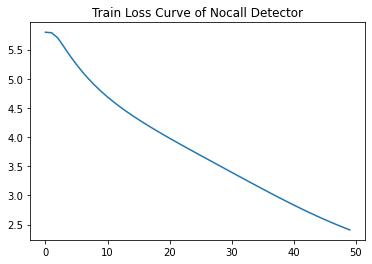

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

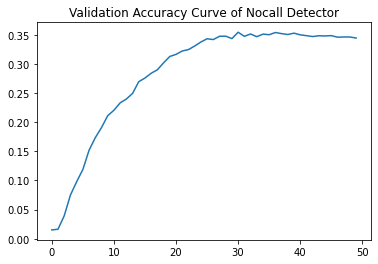

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

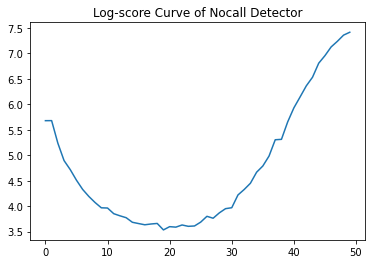

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

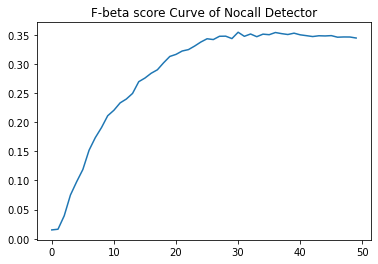

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 34.50
Log Loss score:	7.23
Fbeta-score (beta=1.0): 	0.35
